In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append("../../lib")

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
from costs import compute_mse
from my_regressions import ridge_regression
from my_utils import build_poly

def cross_validation_k(y, x, k_indices, lambda_, degree, k):
    """return the loss of ridge regression."""
    # split indices
    te_indices = k_indices[k]
    index_list = [i for i in range(len(k_indices)) if i != k]
    tr_indices = k_indices[index_list].flatten()
    # get values for indices
    tr_x = build_poly(x[tr_indices], degree)
    te_x = build_poly(x[te_indices], degree)
    tr_y = y[tr_indices]
    te_y = y[te_indices]
    # compute losses
    w, loss_tr = ridge_regression(tr_y, tr_x, lambda_)
    loss_te = compute_mse(te_y, te_x, w)
    return loss_tr, loss_te

def cross_validations_values(y, x, k_indices, lambda_, degree):
    k_fold = len(k_indices)
    return [cross_validation_k(y, x, k_indices, lambda_, degree, k) for k in range(k_fold)]

def cross_validation(y, x, k_indices, lambda_, degree):
    values = cross_validations_values(y, x, k_indices, lambda_, degree)
    return np.mean(values, axis=0)

def cross_validation_std(y, x, k_indices, lambda_, degree):
    values = cross_validations_values(y, x, k_indices, lambda_, degree)
    return np.std(values, axis=0)

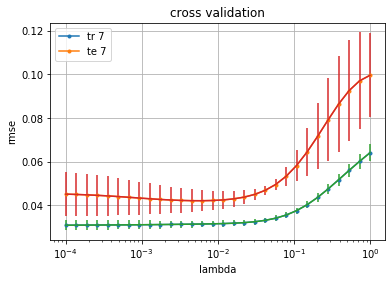

In [5]:
from plots import cross_validation_visualization

def cross_validation_demo(degree = 7, show_error=True):
    seed = 1
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # do it for all lambdas
    values = [cross_validation(y,x,k_indices,l,degree) for l in lambdas]
    std_values = [cross_validation_std(y,x,k_indices,l,degree) for l in lambdas]
    # unzip cross_validation return values between training, test
    rmse_tr, rmse_te = [ i for i, _ in values ], [ j for _, j in values ]
    std_tr, std_te = [ i for i, _ in std_values ], [ j for _, j in std_values ]
    # visualize data
    cross_validation_visualization(
        lambdas,
        rmse_tr,
        rmse_te,
        'tr {}'.format(degree),
        'te {}'.format(degree),
        show_error,
        std_tr,
        std_te,
    )

cross_validation_demo()

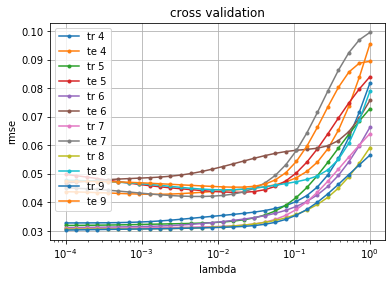

In [6]:
# TODO: how to visualize that?
for degree in range(4,10):
    cross_validation_demo(degree, False)

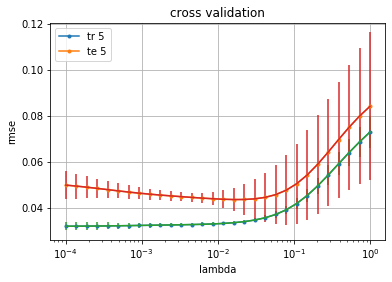

In [7]:
cross_validation_demo(5)

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

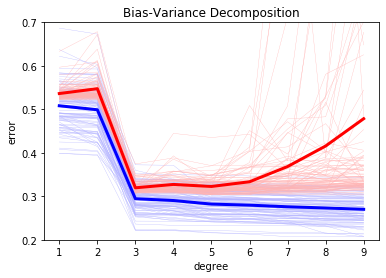

In [8]:
from my_regressions import least_squares
from my_utils import split_data
from my_costs import *
from plots import bias_variance_decomposition_visualization

def bias_variance_demo(
    regression_fn = 'least_squares',
    seeds = range(100),
    num_data = 10000,
    ratio_train = 0.005,
    degrees = range(1, 10)
):
    """The entry."""
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        
        (tr_x, tr_y), (te_x, te_y) = split_data(x, y, ratio_train, seed)
        
        for index_degree, degree in enumerate(degrees):
            tr_x_poly = build_poly(tr_x, degree)
            te_x_poly = build_poly(te_x, degree)
            
            if regression_fn == 'least_squares':
                w, loss = least_squares(tr_y, tr_x_poly, calculate_rmse)
            else:
                lambda_ = find_best_lambda_cv(x, y, degree)
                w, loss = ridge_regression(tr_y, tr_x_poly, lambda_, calculate_rmse)
            
            rmse_tr[index_seed, index_degree] = loss
            rmse_te[index_seed, index_degree] = calculate_rmse(compute_error(te_y, te_x_poly, w))
            
    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo()

# Finding the best hyperparameters

In [9]:
from my_utils import array_map
from my_utils import unzip

def find_best_lambda_cv_weird(x, y, degree, seed = 1, k_fold = 4, lambdas = np.logspace(-4, 0, 30), visualize = False):
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # calculate mean and ste of rmse over folds for all lambdas
    mean_values = [cross_validation(y, x, k_indices, l, degree) for l in lambdas]
    std_values = [cross_validation_std(y, x, k_indices, l, degree) for l in lambdas]
    # unzip cross_validation return values between training, test
    rmse_tr, rmse_te = unzip(mean_values)
    std_tr, std_te = unzip(std_values)
    # let's calculate the worst error possibility
    te_upper_bound = array_map(lambda rmse_std: rmse_std[0]+rmse_std[1], zip(rmse_te, std_te))
    tr_lower_bound = array_map(lambda rmse_std: rmse_std[0]-rmse_std[1], zip(rmse_tr, std_tr))
    # TODO: how should we get this error? can we use the "variance" / do an inter-set computation?
    errors = array_map(lambda te_up_tr_low: te_up_tr_low[0]-te_up_tr_low[1], zip(te_upper_bound, tr_lower_bound))
    best_lambda = lambdas[np.argmin(errors)]
    if visualize:
        cross_validation_visualization(
            lambdas,
            rmse_tr,
            rmse_te,
            'tr {}'.format(degree),
            'te {}'.format(degree),
            True,
            std_tr,
            std_te,
            best_lambda
        )
    return best_lambda

In [10]:
def find_best_lambda_cv(x, y, degree, seed = 1, k_fold = 4, lambdas = np.logspace(-4, 0, 30), visualize = False):
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # calculate mean and ste of rmse over folds for all lambdas
    mean_values = [cross_validation(y, x, k_indices, l, degree) for l in lambdas]
    std_values = [cross_validation_std(y, x, k_indices, l, degree) for l in lambdas]
    # unzip cross_validation return values between training, test
    rmse_tr, rmse_te = unzip(mean_values)
    std_tr, std_te = unzip(std_values)
    # let's calculate the worst error possibility
    te_upper_bound = array_map(lambda rmse_std: rmse_std[0]+rmse_std[1], zip(rmse_te, std_te))
    best_lambda = lambdas[np.argmin(te_upper_bound)]
    if visualize:
        cross_validation_visualization(
            lambdas,
            rmse_tr,
            rmse_te,
            'tr {}'.format(degree),
            'te {}'.format(degree),
            True,
            std_tr,
            std_te,
            best_lambda
        )
    return best_lambda

0.011721022975334805

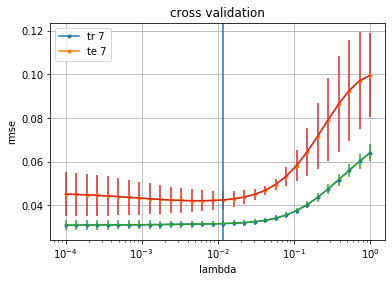

In [11]:
find_best_lambda_cv(x, y, 7, visualize=True)

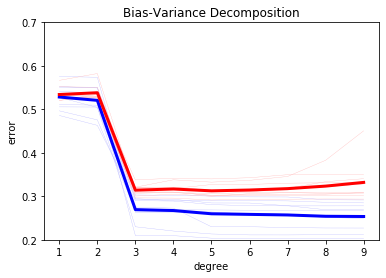

In [12]:
bias_variance_demo(regression_fn = 'ridge_regression', seeds = range(10), num_data = 1000, ratio_train = 0.05, degrees = range(1, 10))